In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
import collections
from sklearn_pandas import DataFrameMapper
from collections import Counter


In [4]:
def preprocessing(txt):
    txt = re.sub('[^a-zA-Z0-9 ]', '', txt)
    txt = txt.lower()
    return txt


In [5]:
train_file = pd.read_csv('../data//train.csv')
final_test_file = pd.read_csv('../data/test.csv')


In [6]:
title1_en=train_file['title1_en'].apply(preprocessing)
title2_en = train_file['title2_en'].apply(preprocessing)
train_file['title1_en']=title1_en
train_file['title2_en']=title2_en

title1_en=final_test_file['title1_en'].apply(preprocessing)
title2_en = final_test_file['title2_en'].apply(preprocessing)
final_test_file['title1_en']=title1_en
final_test_file['title2_en']=title2_en

In [10]:
data_per_class = Counter(train_file['label'])
print("Number of rows grouped by label are:")
for i, label in enumerate(data_per_class):
    print(
        f"{label} class rows: {data_per_class[label]} ({data_per_class[label] / train_file.shape[0]*100:.3f})% of total train data")


Number of rows grouped by label are:
unrelated class rows: 175598 (68.475)% of total train data
agreed class rows: 74238 (28.949)% of total train data
disagreed class rows: 6606 (2.576)% of total train data


In [11]:
label_encoding = {"unrelated": 0, "agreed": 1, "disagreed": 2}

def combine_titles(text):
    return (text['title1_en']+" "+text['title2_en'])

def convert_labels(txt):
    return label_encoding[txt]

train_file['combined_titles'] = train_file[['title1_en', 'title2_en']].apply(combine_titles, axis=1)
train_file['label'] = train_file['label'].apply(convert_labels)
final_test_file['combined_titles'] = final_test_file[['title1_en', 'title2_en']].apply(combine_titles, axis=1)


In [13]:
train_split, validation_split = train_test_split(train_file, test_size=0.3,stratify=train_file['label'],random_state=9)

In [15]:
vectorizer = TfidfVectorizer(stop_words="english", strip_accents="unicode", lowercase=False, encoding='utf-8', min_df=3).fit(train_split['combined_titles'])


In [16]:
train_data=vectorizer.fit_transform(train_split['combined_titles'])
train_labels=train_split['label']

In [21]:
logistic_regression_model = LogisticRegression(penalty="l2",solver="lbfgs",multi_class="multinomial",max_iter=5000, C=0.9).fit(train_data, train_labels)

In [22]:
logistic_regression_model.score(train_data, train_labels)


0.8321532625105148

[0 1 2]


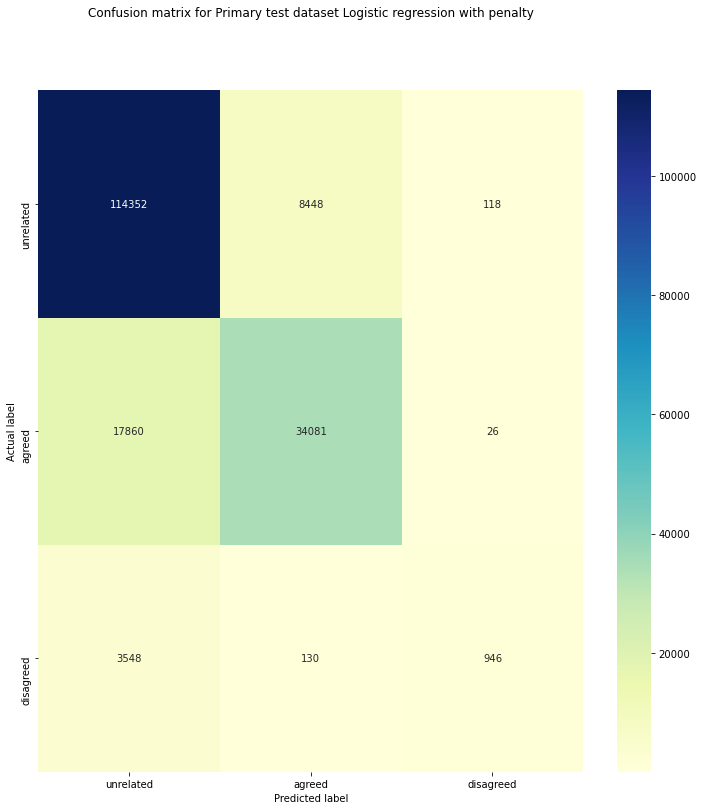

In [43]:
train_hat_labels = logistic_regression_model.predict(train_data)
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(
    train_labels, train_hat_labels)
%matplotlib inline
class_names = ["unrelated", "agreed", "disagreed"]  # name  of classes
# fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))
tick_marks = np.arange(len(class_names))
print(tick_marks)
plt.xticks([0, 1, 2], class_names)
plt.yticks([0, 1, 2], class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_l1_primary_dataset), annot=True,
            cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.title(
    'Confusion matrix for Primary test dataset Logistic regression with penalty', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


In [23]:
valid_data=vectorizer.transform(validation_split['combined_titles'])
valid_labels=validation_split['label']

In [25]:
logistic_regression_model.score(valid_data, valid_labels)


0.80095667658872

In [27]:
valid_hat_labels=logistic_regression_model.predict(valid_data)
valid_hat_labels


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
print(classification_report(valid_labels, valid_hat_labels))


              precision    recall  f1-score   support

           0       0.82      0.91      0.86     52680
           1       0.74      0.60      0.66     22271
           2       0.78      0.19      0.30      1982

    accuracy                           0.80     76933
   macro avg       0.78      0.57      0.61     76933
weighted avg       0.80      0.80      0.79     76933



[0 1 2]


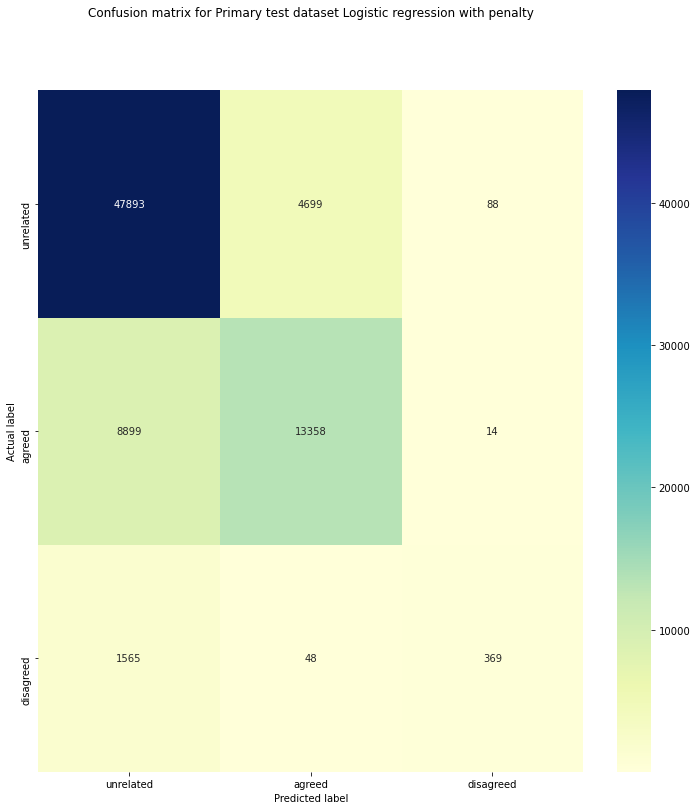

In [42]:
cnf_matrix_l1_primary_dataset = metrics.confusion_matrix(
    valid_labels, valid_hat_labels)
%matplotlib inline
class_names = ["unrelated", "agreed", "disagreed"]  # name  of classes
# fig, ax = plt.subplots()
plt.figure(figsize=(10, 10))
tick_marks = np.arange(len(class_names))
print(tick_marks)
plt.xticks([0, 1, 2], class_names)
plt.yticks([0, 1, 2], class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_l1_primary_dataset), annot=True,
            cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.tight_layout()
plt.title(
    'Confusion matrix for Primary test dataset Logistic regression with penalty', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()


In [30]:
final_test_data=vectorizer.transform(final_test_file['combined_titles'])

In [34]:
final_test_file['label']=logistic_regression_model.predict(final_test_data)


In [38]:
label_decoding = {0: "unrelated", 1: "agreed", 2:"disagreed"}

def convert_labels_to_class(txt):
    return label_decoding[txt]


final_test_file['label'] = final_test_file['label'].apply(convert_labels_to_class)


In [39]:
data_per_class = Counter(final_test_file['label'])
print("Number of rows grouped by label are:")
for i, label in enumerate(data_per_class):
    print(
        f"{label} class rows: {data_per_class[label]} ({data_per_class[label] / final_test_file.shape[0]*100:.3f})% of total train data")


Number of rows grouped by label are:
unrelated class rows: 48438 (75.555)% of total train data
agreed class rows: 15304 (23.871)% of total train data
disagreed class rows: 368 (0.574)% of total train data


In [41]:
final_test_file[['id','label']].to_csv("../data/simple_logistic_regression_test_output_predictions.csv",index=False)